In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,t,uniform,f
from sklearn.linear_model import LinearRegression
import termcolor
from numba import jit

def rprint(string):
    print(termcolor.colored(string, color='green'))

In [2]:
##njit compile

@jit(fastmath=True,parallel=True,inline='always')
def linear_regression_numba(X, y):
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
    theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
    return theta

@jit(fastmath=True)
def RSS(X, model):
    ret=0
    for i in X:
        ret+=(i[:-1]@model[1:].T+model[0]-i[-1])**2
    return ret

@jit(fastmath=True,parallel=True,nogil=True)
def getdeltas(X, bsN):
    deltai = np.zeros((bsN, 6))
    рэсэсы = np.zeros(bsN)
    n_samples = len(X)
    
    for i in range(bsN):
        indices = np.random.randint(0, n_samples, size=n_samples)
        X0 = X[indices]
        X_features = X0[:, :5]
        y = X0[:, -1]
        deltai[i] = linear_regression_numba(X_features, y)
        рэсэсы[i] = RSS(X, deltai[i])
    deltai=deltai.T
    deltai=np.sort(deltai)
    рэсэсы=np.sort(рэсэсы)
    return deltai,рэсэсы


def normal_bs(sgm, bsN):
    нормисы = np.zeros(bsN)
    нормисы = np.random.normal(0, sgm, bsN)
    нормисы=np.sort(нормисы)
    return нормисы

def TSS(X):
    ret=np.sum((X[:,-1]-np.sum(X[:,-1])/len(X))**2)
    return ret


In [3]:
def generate(N):
    ret = np.array([np.zeros(6) for i in range(N)])
    _=uniform(loc=-1, scale=2)
    for i in range(N):
        ret[i,:5]=_.rvs(size=5)
        x1,x2,x3,x4,x5=ret[i,:5]
        ret[i,5]=np.random.normal(2+3*x1-2*x2+x3+x4-x5, 1.5)
        print(*[round(i,2) if i<0 else "+"+str(round(i,2)) for i in ret[i]],sep="\t")
    return ret

In [4]:
N=50
X=generate(N)

-0.67	-0.26	+0.22	+0.2	-0.95	+1.09
-0.29	+0.25	-0.91	+0.55	+0.31	+1.99
+0.19	-0.98	-0.02	+0.92	-0.14	+6.14
-0.81	-0.74	-0.77	-0.11	+0.37	-0.13
-0.28	-0.18	-0.43	-0.1	-0.75	+1.61
+0.44	-0.01	+0.8	-0.17	+0.65	+1.92
+0.8	+0.21	+0.23	+0.8	-0.61	+6.06
-0.16	+0.16	+0.1	-0.27	-0.84	+2.65
+0.38	+0.89	+0.96	+0.79	+0.63	+1.93
+0.89	-0.93	+0.71	+0.05	-0.79	+8.42
+0.82	-0.25	+0.67	+0.13	+0.16	+6.26
+0.66	+0.9	-0.55	+0.54	-0.62	+2.26
-0.65	+0.5	-0.83	-0.07	+0.18	-2.34
+0.73	-0.33	+0.63	-0.48	-0.19	+6.36
+0.32	+0.21	+0.26	+0.12	+0.72	+1.09
+0.51	+0.9	+0.95	+0.15	-0.95	+5.6
-0.74	-0.69	+0.0	+1.0	+0.53	+3.09
-0.78	+0.96	-0.54	-0.46	-0.01	-4.61
-0.44	+0.96	-0.25	-0.37	-0.08	-2.36
+0.27	-0.94	-0.29	-0.68	-0.87	+4.43
+0.01	+0.13	+0.21	+0.38	-0.73	+5.0
+0.27	+0.61	-0.28	+0.6	+0.38	-0.66
-0.94	+0.04	-0.39	+0.97	-0.0	+2.03
+0.78	-0.87	-0.47	+0.17	-0.66	+5.59
-0.25	+0.05	-0.49	-0.04	-0.91	+1.19
+0.36	+0.71	-0.44	-0.04	+0.72	+0.08
+0.99	+0.1	+0.16	+0.07	+0.32	+7.49
-0.52	+0.17	+0.49	+0.4	+0.79	-0.21
+0.01	+0.

In [5]:
nonetha = np.ones(X.shape)
nonetha[:,1:] = X[:,:5]
nonetha[:,0] = 1
F = nonetha.T.dot(nonetha)
#print(F)
rprint(f"a) не являются\n|F| = {round(np.linalg.det(F),2)} >> 1")

a) не являются
|F| = 42265054.03 >> 1


In [6]:
model = linear_regression_numba(nonetha[:,1:], X[:,-1])
model

/tmp/ipykernel_6231/4170485442.py:6: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y


array([ 1.97675392,  3.0810042 , -2.35384846,  1.2906095 ,  1.14610552,
       -1.13676439])

In [7]:
F_1=np.linalg.inv(F)
Rss=RSS(X, model)
delta = model/np.sqrt(Rss*F_1.diagonal())*(N-6)**0.5
print(t.sf(delta,N-6))
rprint("b) значимость определяется на генерацию")
rprint("   β_i:"+str(model)[1:-2])
i=7
#print(np.array(model[1:]).dot(nonetha[i])+model[0], X[i,-1])

/tmp/ipykernel_6231/4170485442.py:13: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  ret+=(i[:-1]@model[1:].T+model[0]-i[-1])**2


[4.92127860e-11 1.17856919e-11 9.99999982e-01 3.32852310e-04
 5.87299012e-03 9.99337764e-01]
b) значимость определяется на генерацию
   β_i: 1.97675392  3.0810042  -2.35384846  1.2906095   1.14610552 -1.1367643


In [8]:
bsN=5000
deltas,ы=getdeltas(X, bsN)
b = 0.95
alf = (1-b)/2
k1 = int(alf*bsN)
k2 = bsN-k1

/tmp/ipykernel_6231/4170485442.py:6: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y


In [9]:
Rss,Tss=RSS(X,model),TSS(X)

_=1-Rss/Tss
rprint(f"c) {_}")
_1,_2=1-ы[k1]/TSS(X),1-ы[k2]/TSS(X)
rprint(f"""   R^2 {"" if _2<_<_1 else "не"} попадает в доверительный интервал BS
   ({round(_2,5)}, {round(_1,5)})\n""")
delta = (Tss-Rss)/5/(Rss/(N-6))
pval=f.sf(delta,5,N-6)
rprint(f"   {pval=}\n   Отвергаем H0 =>...=> не значим")

c) 0.8146331967076997
   R^2 не попадает в доверительный интервал BS
   (0.74852, 0.81067)

   pval=np.float64(4.960315413249888e-15)
   Отвергаем H0 =>...=> не значим


In [10]:
rprint(f"d) при x_k==0 значение будет {round(model[0],4)}")
rprint(f"   доверительный интервал: ({round(deltas[0,k1],4)}, {round(deltas[0,k2],4)})")

d) при x_k==0 значение будет 1.9768
   доверительный интервал: (1.5723, 2.3934)


In [11]:
e = [i[:-1]@model[1:].T+model[0]-i[-1] for i in X]
In=0
for i in range(len(X)):
    for j in range(i+1,len(X)):
        In+=e[i]<e[j]

delta = (In-N*(N-1)/4)/(N**3/36)**0.5
pval=norm.sf(delta)

rprint(f"e) {pval=}\n   Не отвергаем H0 => независимы")

e) pval=np.float64(0.42928652457419136)
   Не отвергаем H0 => независимы


In [12]:
#Калмогоров
bsN=100000
sgm = Rss/(N-6)
sgm
deltas=normal_bs(sgm,bsN)
pval=np.where((deltas)*N**0.5 > np.max(e))[0][0]/bsN
rprint(f"f) {pval=}\n   Не отвергаем H0 => Распределено нормально")

f) pval=np.float64(0.57992)
   Не отвергаем H0 => Распределено нормально


g) Выбросов нет


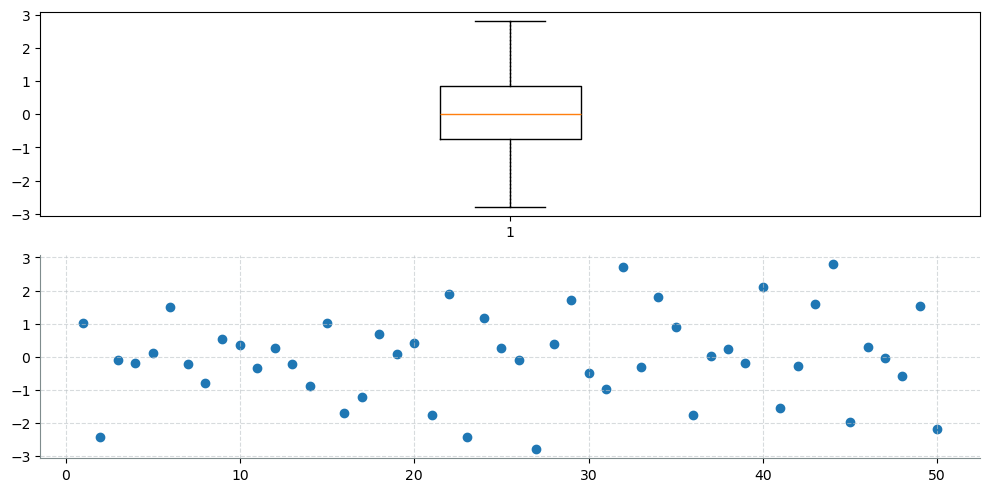

In [13]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
rprint("g) Выбросов нет") #FIXME


e1 = np.sort(e)
ax1.plot([1,1],[e1[3*N//4],e1[-1]],linestyle='dotted',linewidth=1, color="black")
ax1.plot([1,1],[e1[0],e1[N//4]],linestyle='dotted',linewidth=1, color="black")
box=ax1.boxplot(e1,showfliers=False)
ax2.scatter([i+1 for i in range(N)],e)
plt.grid(True, linestyle='--', alpha=0.6, color='#bdc3c7')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#7f8c8d')
ax.spines['bottom'].set_color('#7f8c8d')

plt.tight_layout()


In [14]:
CUSS=0
for i in range(len(X)):
    X0=X[[j!=i for j in range(len(X))]]
    model_=linear_regression_numba(X0[:,:-1], X0[:,-1])
    p=X[i]
    CUSS+=(p[:-1]@model_[1:].T+model_[0]-p[-1])**2
rprint(f"h) CUSS = {float(CUSS)}")
rprint(f"   R_cu^2 = {(Tss-CUSS)/Tss}\n   предсказательная способность есть(не нулевая)")


h) CUSS = 109.5326413414693
   R_cu^2 = 0.7653058163508362
   предсказательная способность есть(не нулевая)


In [15]:
p=X[np.random.randint(N)]
sgm2=5/4*((p[:-1]@model_[1:].T+model_[0]-p[-1])**2)
delta = Rss/(N-6)/sgm2
pval=f.sf(delta,N-6,5-1)

rprint(f"""i) pval={float(pval)}\n   {"" if pval<0.05 else "не"} отвергаем H0 =>
                    Модель {"" if pval<0.05 else "не"}адекватна""")

i) pval=5.430720704569016e-05
    отвергаем H0 =>
                    Модель адекватна


In [16]:
def Покупка_обезьяны():
    return "-100руб"

def Запрос_alf_от_обезьяны(mx):
    return np.random.rand()*mx

def Обезьяна_гений_знак_вопроса(delta, alf):
    return len(np.where(delta>alf)[0])==1

def Продажа_обезьяны():
    return "+105руб"

delta = model/np.sqrt(Rss*F_1.diagonal())*(N-6)**0.5
pvals=t.sf(delta,N-6)
alf=0
while(True):
    Покупка_обезьяны()
    alf = Запрос_alf_от_обезьяны(np.max(pvals))
    if Обезьяна_гений_знак_вопроса(pvals, alf):
        break
    Продажа_обезьяны()

print(pvals)
print(alf)

[4.92127860e-11 1.17856919e-11 9.99999982e-01 3.32852310e-04
 5.87299012e-03 9.99337764e-01]
0.9998422859089746


In [17]:
Xdel=np.delete(X,np.where(pvals>alf)[0],1)

nonethadel = np.ones(Xdel.shape)
nonethadel[:,1:] = Xdel[:,:4]
nonethadel[:,0] = 1
Fdel = nonethadel.T.dot(nonethadel)

modeldel = linear_regression_numba(nonethadel[:,1:], Xdel[:,-1])

Fdel_1=np.linalg.inv(Fdel)
Rssdel=RSS(Xdel, modeldel)
deltadel = modeldel/np.sqrt(Rssdel*Fdel_1.diagonal())*(N-5)**0.5
print(t.sf(deltadel,N-5))
rprint("j.b) значимость определяется на генерацию")
rprint("     β_i:"+str(modeldel)[1:-2])
i=7
#print(np.array(model[1:]).dot(nonetha[i])+model[0], X[i,-1])

[2.12497592e-09 9.94295118e-11 9.99998991e-01 7.32740822e-03
 9.98920637e-01]
j.b) значимость определяется на генерацию
     β_i: 1.91774516  3.19141686 -2.14551102  1.24755665 -1.2160051


In [18]:
Tssdel = TSS(Xdel)
deltadel = (Tssdel-Rssdel)/4/(Rssdel/(N-5))
pval=f.sf(deltadel,4,N-5)
rprint(f"jc) {pval=}\n    Отвергаем H0 =>...=> не значим")

jc) pval=np.float64(2.445704163835772e-13)
    Отвергаем H0 =>...=> не значим


In [21]:
def getdeltas_del(X, ind):
    Xdel=np.delete(X,ind,1)
    deltai = np.zeros((bsN, 6))
    deltaidel = np.zeros((bsN, 5))
    рэсэсы = np.zeros(bsN)
    n_samples = len(X)
    
    for i in range(100000):
        indices = np.random.randint(0, n_samples, size=n_samples)
        X0 = X[indices]
        X0del = Xdel[indices]
        X_features = X0[:, :5]
        Xdel_features = X0[:, :4]
        y = X0[:, -1]
        ydel = X0del[:, -1]
        deltai[i] = linear_regression_numba(X_features, y)
        deltaidel[i] = linear_regression_numba(Xdel_features, ydel)
        рэсэсы[i] = RSS(X, deltai[i])**2-RSS(Xdel, deltaidel[i])**2
    deltai=deltai.T
    deltai=np.sort(deltai)
    рэсэсы=np.sort(рэсэсы)
    return deltai,рэсэсы

In [22]:
bsN=100000
_,рэсэсы=getdeltas_del(X, np.where(pvals>alf)[0])

In [26]:
alf = 0.05
k1 = int(alf*bsN)
k2 = bsN-k1
rprint(f"k) Интервал: ({рэсэсы[k1]}, {рэсэсы[k2]})")
_ = рэсэсы[k1] <0< рэсэсы[k2]
rprint(f"   0 {"" if _ else "не"} входит в интервал")
rprint(f"   различия {"не" if _ else ""} значемы")

k) Интервал: (-66207.20621509444, -15336.966733055095)
   0 не входит в интервал
   различия  значемы


In [31]:
! fortune|cowsay -e -o

 ________________________________________
/ Running Windows on a Pentium is like   \
| having a brand new Porsche but only be |
| able to drive backwards with the       |
| handbrake on.                          |
|                                        |
\ -- Unknown source                      /
 ----------------------------------------
        \   ^__^
         \  (-o)\_______
            (__)\       )\/\
                ||----w |
                ||     ||
